In [ ]:
#!pip install numpy
!pip install matplotlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Constants and initial conditions for Test 1
gamma = 1.4  # Specific heat ratio for ideal gas
M = 200  # Number of cells for spatial discretization
x0 = 0.3  # Position of initial discontinuity
x = np.linspace(0, 1, M)  # Spatial domain from 0 to 1
dx = x[1] - x[0]  # Delta x, the distance between cell centers

In [5]:
# Initial conditions for density (rho), velocity (u), and pressure (p)
WL = np.array([1.0, 0.75, 1.0])  # Left state (rho, u, p)
WR = np.array([0.125, 0.0, 0.1])  # Right state (rho, u, p)
U = np.zeros((3, M))  # Array to store the solution

In [6]:
# Assign initial conditions to the solution array
U[:, :int(M * x0)] = WL.reshape(3, 1)
U[:, int(M * x0):] = WR.reshape(3, 1)

# Convert initial pressure to total energy for conservative form
U[1, :] *= U[0, :]  # Convert velocity to momentum (rho*u)
U[2, :] = U[2, :] / (gamma - 1) + 0.5 * U[1, :]**2 / U[0, :]  # Convert pressure to total energy (rho*e)

In [7]:
# Define the Steger-Warming FVS scheme function
def steger_warming(U, dx, dt, gamma):
    # Convert conservative variables (U) to primitive variables (rho, u, p, e)
    rho = U[0, :]
    u = U[1, :] / rho
    e = U[2, :] / rho
    p = (gamma - 1) * rho * (e - 0.5 * u**2)

    # Calculate flux for each component of U
    F = np.zeros_like(U)
    F[0, :] = rho * u  # Mass flux rho*u
    F[1, :] = rho * u**2 + p  # Momentum flux rho*u^2 + p
    F[2, :] = (U[2, :] + p) * u  # Energy flux (rho*e + p)*u

    # Eigenvalues (for the splitting)
    a = np.sqrt(gamma * p / rho)
    lambda_1 = u - a
    lambda_3 = u + a

    # Splitting of fluxes into positive and negative parts
    F_plus = 0.5 * (F + np.abs(lambda_1) * U)
    F_minus = 0.5 * (F - np.abs(lambda_3) * U)

    # Compute numerical flux at interfaces
    num_flux = F_plus[:, :-1] + F_minus[:, 1:]

    # Update the conservative variables in the domain (excluding boundaries)
    U[:, 1:-1] -= (dt / dx) * (num_flux[:, 1:] - num_flux[:, :-1])

    # Apply transmissive boundary conditions
    U[:, 0] = U[:, 1]
    U[:, -1] = U[:, -2]

    return U


In [10]:
# Setup for time-stepping
t_final = 0.2  # Final time to reach
CFL = 0.9  # Courant number for stability
u_max = max(np.abs(U[1, :] / U[0, :]) + np.sqrt(gamma * (gamma - 1) * U[2, :] / U[0, :]))
dt = CFL * dx / u_max  # Time step based on CFL condition

In [ ]:

# Time integration using the Steger-Warming FVS scheme
t = 0
while t < t_final:
    # Adjust dt to finish exactly at t_final
    if t + dt > t_final:
        dt = t_final - t
    U = steger_warming(U, dx, dt, gamma)
    t += dt


In [12]:
# Extract physical quantities from the conservative variables
rho = U[0, :]  # Density
u = U[1, :] / rho  # Velocity
e = U[2, :] / rho  # Specific internal energy
p = (gamma - 1) * rho * (e - 0.5 * u**2)  # Pressure


In [13]:
# Plotting the results for density, velocity, pressure, and internal energy
plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

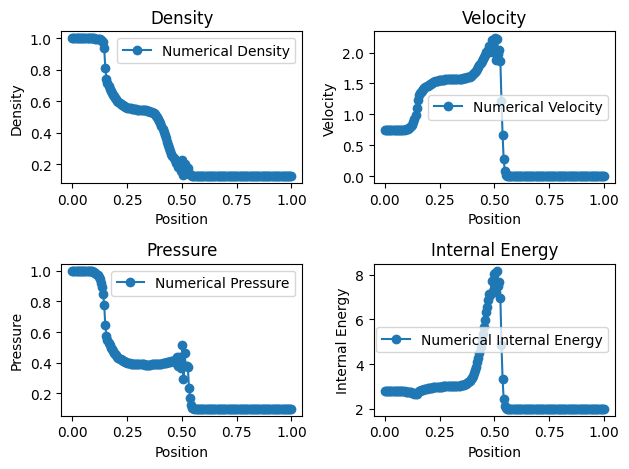

In [14]:

# Density plot
plt.subplot(2, 2, 1)
plt.plot(x, rho, '-o', label='Numerical Density')
plt.title('Density')
plt.xlabel('Position')
plt.ylabel('Density')

# Velocity plot
plt.subplot(2, 2, 2)
plt.plot(x, u, '-o', label='Numerical Velocity')
plt.title('Velocity')
plt.xlabel('Position')
plt.ylabel('Velocity')

# Pressure plot
plt.subplot(2, 2, 3)
plt.plot(x, p, '-o', label='Numerical Pressure')
plt.title('Pressure')
plt.xlabel('Position')
plt.ylabel('Pressure')

# Internal energy plot
plt.subplot(2, 2, 4)
plt.plot(x, e, '-o', label='Numerical Internal Energy')
plt.title('Internal Energy')
plt.xlabel('Position')
plt.ylabel('Internal Energy')

# Show the plots with a legend
for i in range(1, 5):
    plt.subplot(2, 2, i).legend()
plt.tight_layout()
plt.show()